Start analyse case sweep_data_2017_12_10_19_05
Time up to 3252.374755859375:3542.363037109375
U0 64.24209377605372 W0 -1.1477373864894442 th0 -0.004783792053474051
Sample rate is 41.84651858237806
Sample rate is 41.84651858237806
Composite using [5, 26, 48, 69, 91]
Composite using [5, 26, 48, 69, 91]


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Saved Freq Res to ../data/sweep_data_2017_12_10_19_05_freqres.pkl


No handles with labels found to put in legend.
No handles with labels found to put in legend.


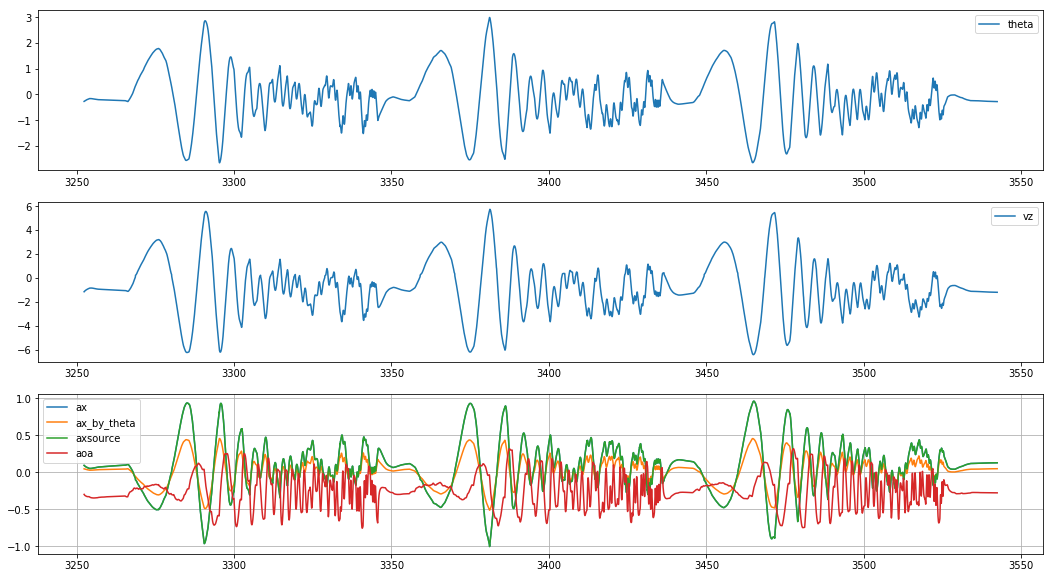

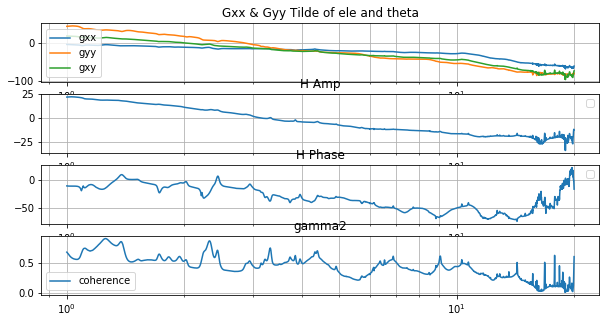

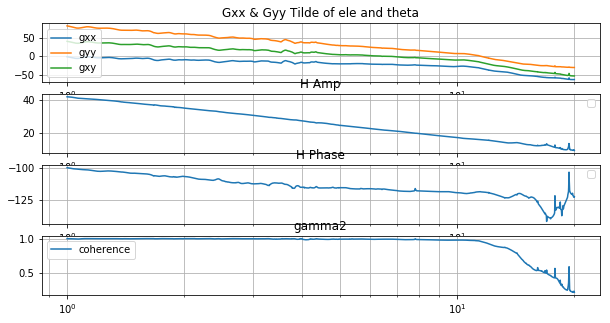

Stored 'freqres' (FreqIdenSIMO)


In [2]:
%matplotlib inline

import sys
sys.path.insert(0, '../')

from AircraftIden import FreqIdenSIMO, TransferFunctionFit
import numpy as np

import matplotlib.pyplot as plt
import math
import pickle
from os.path import basename,splitext

plt.rc('figure', figsize=(10.0, 5.0))

def lat_dyn_freq(fn,show_freq_iden_plots=True):
    name = splitext(basename(fn))[0]
    arr = np.load(fn)
    print("Start analyse case {}".format(name))
    time_seq = arr[:, 0]
    print("Time up to {}:{}".format(time_seq[0],time_seq[-1]))
    ele_seq = arr[:, 1]
    q_seq = arr[:, 4]
    vvi_seq = arr[:, 6]
    theta_seq = arr[:, 2] / 180 * math.pi
    airspeed_seq = arr[:, 3]
    aoa_seq = arr[:, 5] / 180 * math.pi

    vx_seq = arr[:, 8]
    vy_seq = arr[:, 9]
    vz_seq = arr[:, 10]

    ax_source = arr[:, 11].copy()
    ax_seq = arr[:, 11]  # + np.sin(theta_seq) * 9.8
    # ay_seq = arr[:, 12]
    az_seq = arr[:, 13]
    print("U0 {} W0 {} th0 {}".format(vx_seq[0],vz_seq[0],theta_seq[0]))
    # X = [u,w,q,th]
    # Y = [w,q,th,ax,az]
    # Note ax ay contain gravity acc
    simo_iden = FreqIdenSIMO(time_seq, 1, 20, q_seq,vx_seq, vz_seq)
    freqres = simo_iden.get_freqres()
    output_path = "../data/{}_freqres.pkl".format(name)
    with open(output_path, 'wb') as output:
        pickle.dump(simo_iden, output, pickle.HIGHEST_PROTOCOL)
        print("Saved Freq Res to {}".format(output_path))

    if show_freq_iden_plots:
        fig = plt.figure("source data")
        fig.set_size_inches(18, 10)
        plt.subplot(311)
        # plt.plot(time_seq, aoa_seq * 180 / math.pi, label='aoa')
        plt.plot(time_seq, theta_seq * 180 / math.pi, label='theta')
        # plt.plot(time_seq, az_seq - az_seq[0], label='az - {:2.1f}'.format(az_seq[0]))
        plt.legend()

        plt.subplot(312)
        plt.plot(time_seq, vz_seq, label='vz')
        # plt.plot(time_seq, vx_seq - vx_seq[0], label='vx - {:3.1f}'.format(vx_seq[0]))
        plt.legend()

        plt.subplot(313)
        # plt.plot(time_seq, q_seq, label='q')
        # plt.plot(time_seq, theta_seq*57, label='theta')
        plt.plot(time_seq, ax_seq, label='ax')
        plt.plot(time_seq, - np.sin(theta_seq) * 9.8, label='ax_by_theta')
        plt.plot(time_seq, ax_source, label='axsource')
        plt.plot(time_seq, aoa_seq * 50, label='aoa')
        plt.grid(which='both')
        # plt.plot(time_seq, ele_seq, label="ele")

        plt.legend()
        plt.figure("Q->U(vx)")
        simo_iden.plt_bode_plot(0)
        plt.figure("Q->W(vz)")
        simo_iden.plt_bode_plot(1)
        plt.show()
        
    return simo_iden





fn = "../data/sweep_data_2017_12_10_19_05.npy"
freqres = lat_dyn_freq(fn,show_freq_iden_plots=True)
%store freqres

In [8]:
import sys
sys.path.insert(0, '../')
from AircraftIden import FreqIdenSIMO, TransferFunctionFit
import math
import matplotlib.pyplot as plt

%store -r
# X = [u,w,th]
# Y = [u,w]
import sympy as sp
from AircraftIden.StateSpaceIden import StateSpaceIdenSIMO, StateSpaceParamModel


M = sp.Matrix([[1, 0, 0],
               [0, 1 , 0],
               [0, 0, 1]])

# Tailsittel
#    0---Vx, W
#--- | ----
# |  |  |
#    |
#  Vz ,-U
# 10m/s 

# Vz trim is -6.05,Vz is negative U
# Vx trim is 4.55, Vx is W
g = 9.78

Xu, Xw, Xq = sp.symbols('Xu Xw Xq')
Zu, Zw, Zq = sp.symbols('Zu Zw Zq')
Mu, Mw, Mq = sp.symbols('Mu Mw Mq')

def callback(xk,state):
    print(xk)
    print(state)
    
def process_ssm(freqres,trims):
    th0 = trims["theta"]
    W0 = trims["W0"]
    U0 = trims["U0"]
    F = sp.Matrix([[Xu, Xw, -g * math.cos(th0)],
               [Zu, Zw, -g * math.sin(th0)],
               [0, 0, 0]])
    G = sp.Matrix([[Xq-W0],[Zq+U0],[1]])
    # direct using u w q for y
    #U equal to negative u
    H0 = sp.Matrix([
        [1, 0, 0],
        [0, 1, 0]])
    H1 = sp.Matrix([
        [0, 0, 0],
        [0, 0, 0],
    ])
    syms = [Xu, Xw,Zu, Zw,Zq,Xq]
    LatdynSSPM = StateSpaceParamModel(M, F, G, H0, H1, syms)
    
    plt.rc('figure', figsize=(10.0, 5.0))
    freqres = freqres.get_freqres(indexs = [0,1])
    ssm_iden = StateSpaceIdenSIMO(freqres, accept_J=20,
                              enable_debug_plot=False,
                              y_names=['U',"w"],reg=0, cpu_use = 32, max_sample_times=20)
    J, ssm = ssm_iden.estimate(LatdynSSPM, syms, constant_defines={},rand_init_max = 10)
    ssm.check_stable()
    ssm_iden.draw_freq_res()
    ssm_iden.print_res()

Will estimate num 6 [A_0_0, A_0_1, A_1_0, A_1_1, B_0_0, B_1_0]
Found new better 2023.4624043416047
Found new better 1806.9347028840377
Found new better 1674.1548124737517
Found new better 257.8705342119487
Found new better 254.19320041159568
Found new better 224.33615595608097
Found new better 91.75556578034339
All in pool finish
Eigs [-2.83874053e-13+0.04497049j -2.83874053e-13-0.04497049j
  0.00000000e+00+0.        j]
Stable
{Xu: -0.344130220401628, Xw: -0.0164406402081930, Zu: 7.32623255749144, Zw: 0.344130220401060, Zq: 14.8797017340974, Xq: 1.87571424632596}
A
[[-0.34413022 -0.01644064 -9.78      ]
 [ 7.32623256  0.34413022  0.        ]
 [ 0.          0.          0.        ]]
B
[[ 3.01571425]
 [79.11970173]
 [ 1.        ]]


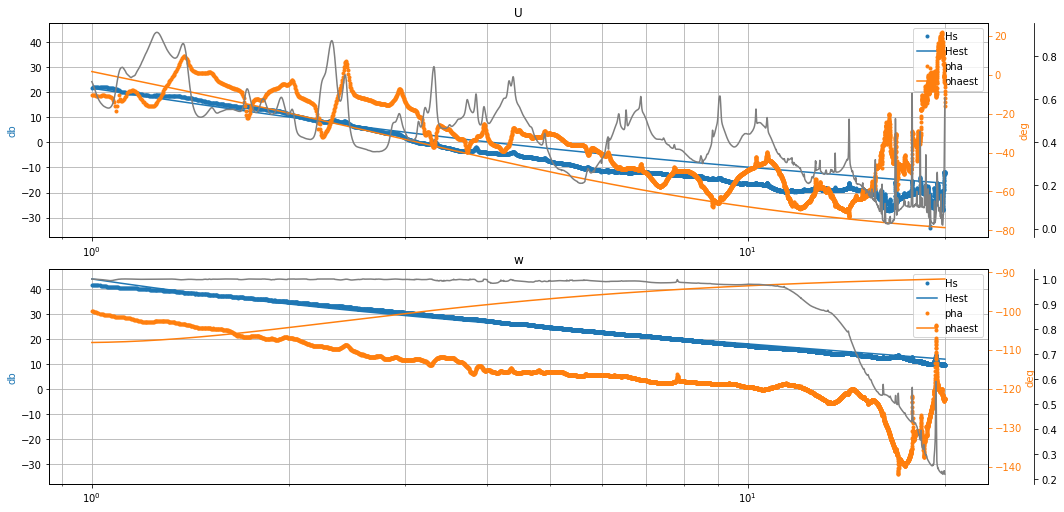

In [9]:
process_ssm(freqres,{
    "theta":0,
    "U0":64.24,
    "W0":-1.14
    })

In [ ]:
def process_status_freqres(freqres, i):
    freq, H, gamma2, gxx, gxy, gyy = freqres.get_freq_iden(i)
    a,b,c,d,tau,s = sp.symbols("a b c d tau s")
    
    num = d
    den = s*(b *s + c)
    tfpm = TransferFunctionParamModel(num,den,tau)
    fitter = TransferFunctionFit(freq, H, gamma2, tfpm,nw=20,iter_times=1000,reg = 0)
    tf = fitter.estimate(10,accept_J=20)
    return fitter

plt.rc('figure', figsize=(20.0, 10.0))
def plot_fitter(fitter, status_name):
    plt.figure(status_name)
    fitter.plot(status_name+":")
    trans_str = fitter.latex()
    plt.text(20, 0,trans_str, fontsize=20,color='red')
    plt.show()

    
def poly_latex(poly,cha = "s"):
    ret_str = ""
    ords = len(poly) - 1
    for i in range(ords+1):
        ordn = ords - i
        if ordn == 0:
            ret_str = ret_str + "{:4.2f}".format(poly[i])
        else:
            if (poly[i] == 1):
                ret_str = ret_str + "s^{:d}+".format(ordn) 
            else:
                ret_str = ret_str + "{:4.2f} s^{:d}+".format(poly[i],ordn)
    return ret_str

def transfer_func_latex(num,den,tau):
    return r"$\frac{" + poly_latex(num) + "}{" + poly_latex(den) +"}" + "e^{-" + "{:4.3f}".format(tau) + "t}$"